In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gymnasium as gym
import torch
from torch import nn
from torch import optim
from torchsummary import summary
import seaborn as sns

sns.set()

## Helper Functions

In [2]:
def create_minibatches(batch_size, *arrays):
    n = len(arrays[0]) # assume all arrays have same length
    assert all(len(arr) == n for arr in arrays), "All input arrays must have the same length"


    # shuffle indices
    indices = np.random.permutation(n)
    shuffled_arrays = [arr[indices] for arr in arrays]

    for start_ind in range(0, n, batch_size):
        end_ind = min(start_ind + batch_size, n)
        yield tuple(arr[start_ind:end_ind] for arr in shuffled_arrays)
 

In [3]:
def random_rollout(env, device):
    state, _ = env.reset()
    terminated, truncated = False, False

    states_actions = []

    while not terminated and not truncated:
        # if len(states_actions) >= 5: break

        action = env.action_space.sample()
        next_state, _, terminated, truncated, _ = env.step(action)

        states_actions.append(np.concatenate((state, action)))

        state = next_state
    
    states_actions = torch.FloatTensor(np.array(states_actions))

    return states_actions

def old_random_rollout(env, device):
    state, _ = env.reset()
    terminated, truncated = False, False

    states_actions = []
    next_states = []

    while not terminated and not truncated:
        # if len(states_actions) >= 5: break

        action = env.action_space.sample()
        next_state, _, terminated, truncated, _ = env.step(action)

        states_actions.append(np.concatenate((state, action)))
        next_states.append(next_state)

        state = next_state
    
    states_actions = torch.FloatTensor(np.array(states_actions))
    next_states = torch.FloatTensor(next_states)

    return states_actions, next_states

In [4]:
def collect_samples(env, n_iter, normalize_velocity=True):
    states_actions = []

    # Collect Data
    for i in range(n_iter):
        states_actions.append(random_rollout(env, "cpu"))

    states_actions = torch.stack(states_actions)

    # Normalize velocity between -1 and 1
    if normalize_velocity:
        states_actions[:,:,2] /= 8

    return states_actions

In [5]:
def plot_feature_trajectory(ax, feature, title, n_iter, horizon, color="blue", plot_individual=True):
    if plot_individual:
        for i in range(n_iter):
            ax.plot(feature[i, :], alpha = 0.05, color="gray")
    
    avg = torch.mean(feature, dim=0)
    std = torch.std(feature, axis=0)
    ax.plot(avg, color=color, label=title + " mean")
    ax.fill_between(
        np.arange(horizon),
        avg - std,
        avg + std,
        color=color, alpha=0.3,
        label=title + '± 1 Std Dev'
    )
    ax.legend(loc="upper left")

In [6]:
# initialize environment
env = gym.make("Pendulum-v1", render_mode=None)
obs_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.shape[0]

## RNN

In [7]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        return out, ht

In [8]:
def get_sequences_from_data(data, sequence_length):
    output = []

    for i in range(len(data) - sequence_length + 1):

        sequence = data[i: i + sequence_length]
        output.append(sequence)
    
    output = torch.stack(output, dim=0)

    return output

get_sequences_from_data(torch.FloatTensor([1, 2, 3, 4, 5]), 2) # test

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

In [9]:
def train_rnn(env, model, num_epochs, num_episodes, sequence_length, batch_size, lr, device, multistep=False):
    losses = []
    loss_fn = nn.MSELoss()

    opt = optim.Adam(model.parameters(), lr=lr)

    # Collect Data
    t0_states_actions = [[] for i in range(num_episodes)]
    t1_actions = [[] for i in range(num_episodes)]
    t1_states = [[] for i in range(num_episodes)] # for testing
    t2_states = [[] for i in range(num_episodes)]
    
    for i in range(num_episodes):
        with torch.no_grad():
            states_actions = random_rollout(env, device)
            states_actions[:,2] /= 8

            t0_states_actions[i] = states_actions[:-2,]
            t1_actions[i] = states_actions[1:-1, 3].unsqueeze(dim=1)
            t1_states[i] = states_actions[1:-1, :3]
            t2_states[i] = states_actions[2:, :3]

            t0_states_actions[i] = get_sequences_from_data(t0_states_actions[i], sequence_length)
            t1_actions[i] = get_sequences_from_data(t1_actions[i], sequence_length)
            t1_states[i] = get_sequences_from_data(t1_states[i], sequence_length)
            t2_states[i] = get_sequences_from_data(t2_states[i], sequence_length)
    
    t0_states_actions = torch.concatenate(t0_states_actions)
    t1_actions = torch.concatenate(t1_actions)
    t1_states = torch.concatenate(t1_states)
    t2_states = torch.concatenate(t2_states)

    # print(t0_states_actions.shape)
    # print(t1_states.shape)

    # Train Model
    for epoch in range(num_epochs):

        for b_t0_states_actions, b_t1_actions, b_t1_states, b_t2_states in create_minibatches(batch_size, t0_states_actions, t1_actions, t1_states, t2_states):
            noise = torch.randn(b_t0_states_actions.shape) * 0.005 # Add noise to states
            noise[:,:,3] = 0 # Remove noise from actions

            t1_predicted_states, _ = model(b_t0_states_actions) # ignore hidden space ht
            model_loss = loss_fn(t1_predicted_states, b_t1_states)

            if multistep:
                next_state_actions = torch.cat((b_t1_actions, t1_predicted_states), dim=2)
                t2_predicted_states, _ = model(next_state_actions)
                model_loss += loss_fn(t2_predicted_states, b_t2_states)
                
            opt.zero_grad()
            model_loss.backward()
            opt.step()

            losses.append(model_loss.item())

    return losses

In [15]:
# rnn_model = SimpleRNN(obs_space_size, action_space_size, hidden_size=64)
# losses = train_rnn(env, rnn_model, num_epochs=100, num_episodes=200, sequence_length=10, batch_size=256, lr=1e-4, device="cpu", multistep=False) # multistep no work
# plt.plot(losses)
# plt.yscale("log")

## Test RNN

In [13]:
"""
1 step prediction, empty hidden state every time
"""

with torch.no_grad():
    states_actions, next_states = old_random_rollout(env, device="cpu")
    states_actions[:,2] /= 8
    next_states[:,2] /= 8
    states_actions = get_sequences_from_data(states_actions, 1)
    next_state_predictions, _ = rnn_model(states_actions)

# next_state_predictions = next_state_predictions[0]
# next_state_predictions.shape

x = next_state_predictions[:,0,0]
y = next_state_predictions[:,0,1]

lengths = x ** 2 + y ** 2
lengths_mean = lengths.mean()
lengths_std = lengths.std()

fig, axs = plt.subplots(1, 2)
axs[0].plot(lengths)
axs[0].hlines(lengths_mean, 0, 200, label="mean")
axs[0].fill_between((0, 200), lengths_mean - lengths_std, lengths_mean + lengths_std, color='cornflowerblue', alpha=0.3, label='± 1 Std Dev')
axs[0].set_title("Pendulum Lengths")
axs[0].legend()

horizon = 20
axs[1].plot(x[:horizon], y[:horizon], color="blue", label="predicted")
axs[1].plot(next_states[:horizon,0], next_states[:horizon,1], color="red", label="true")
axs[1].set_title("True vs 1-Step Prediction")
axs[1].legend(loc="upper right")
axs[1].set_ylim(-1.2, 1.2)
axs[1].set_xlim(-1.2, 1.2)

fig.tight_layout()

NameError: name 'rnn_model' is not defined

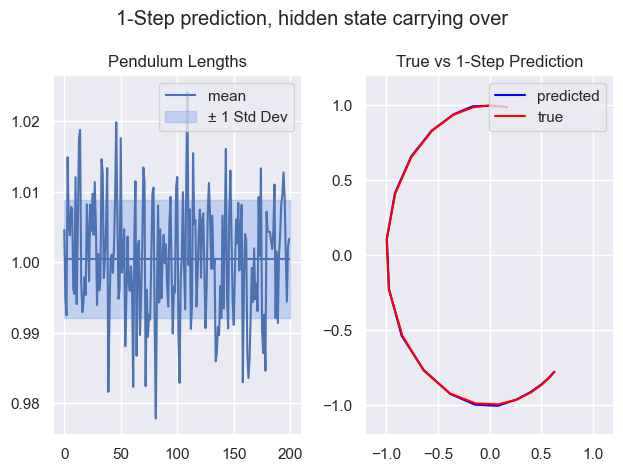

In [ ]:
"""
1-Step prediction, hidden state carrying over
"""
with torch.no_grad():
    states_actions, next_states = old_random_rollout(env, device="cpu")
    states_actions[:,2] /= 8
    next_states[:,2] /= 8
    next_state_predictions, _ = rnn_model(states_actions.unsqueeze(dim=0))

next_state_predictions = next_state_predictions[0]

x = next_state_predictions[:,0]
y = next_state_predictions[:,1]

lengths = x ** 2 + y ** 2
lengths_mean = lengths.mean()
lengths_std = lengths.std()

fig, axs = plt.subplots(1, 2)
axs[0].plot(lengths)
axs[0].hlines(lengths_mean, 0, 200, label="mean")
axs[0].fill_between((0, 200), lengths_mean - lengths_std, lengths_mean + lengths_std, color='cornflowerblue', alpha=0.3, label='± 1 Std Dev')
axs[0].set_title("Pendulum Lengths")
axs[0].legend()

horizon = 20
axs[1].plot(x[:horizon], y[:horizon], color="blue", label="predicted")
axs[1].plot(next_states[:horizon,0], next_states[:horizon,1], color="red", label="true")
axs[1].set_title("True vs 1-Step Prediction")
axs[1].legend(loc="upper right")
axs[1].set_ylim(-1.2, 1.2)
axs[1].set_xlim(-1.2, 1.2)

fig.suptitle("1-Step prediction, hidden state carrying over")
fig.tight_layout()

In [30]:
def rnn_rollout(model, n_iter, horizon, states_actions=None):

    # Collect Data
    if states_actions is None:
        states_actions = collect_samples(env, n_iter, normalize_velocity=True)

    # Start with same start states
    input = states_actions[:,0,:]
    ht = None

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        input = input.reshape(n_iter, 1, 4)

        with torch.no_grad():
            pred, ht = model(input, ht)
    
        input = torch.concatenate((pred, states_actions[:, i, 3].reshape(n_iter, 1, 1)), dim=2)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1).squeeze(dim=2) # dim 2 is the sequence

    return preds, states_actions

# n_iter = 150
# horizon = 150
# preds, states_actions = rnn_rollout(rnn_model, n_iter, horizon)

# print(f"{preds.shape = }")
# print(f"{states_actions.shape = }")
       

Text(0, 0.5, 'y')

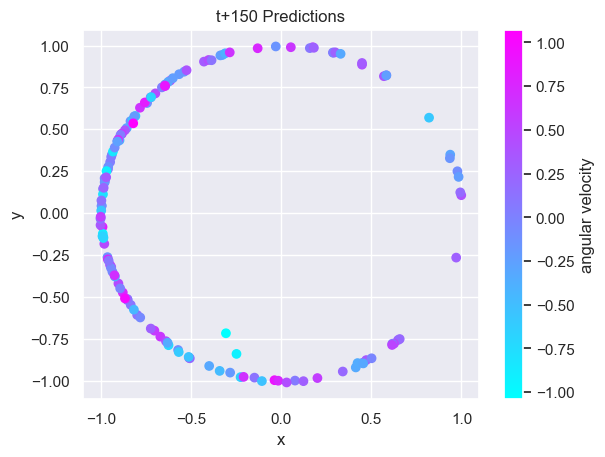

In [ ]:
n = 149
sc = plt.scatter(preds[:,n,0], preds[:,n,1], c=preds[:,n,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title(f"t+{n+1} Predictions")
plt.xlabel("x")
plt.ylabel("y")

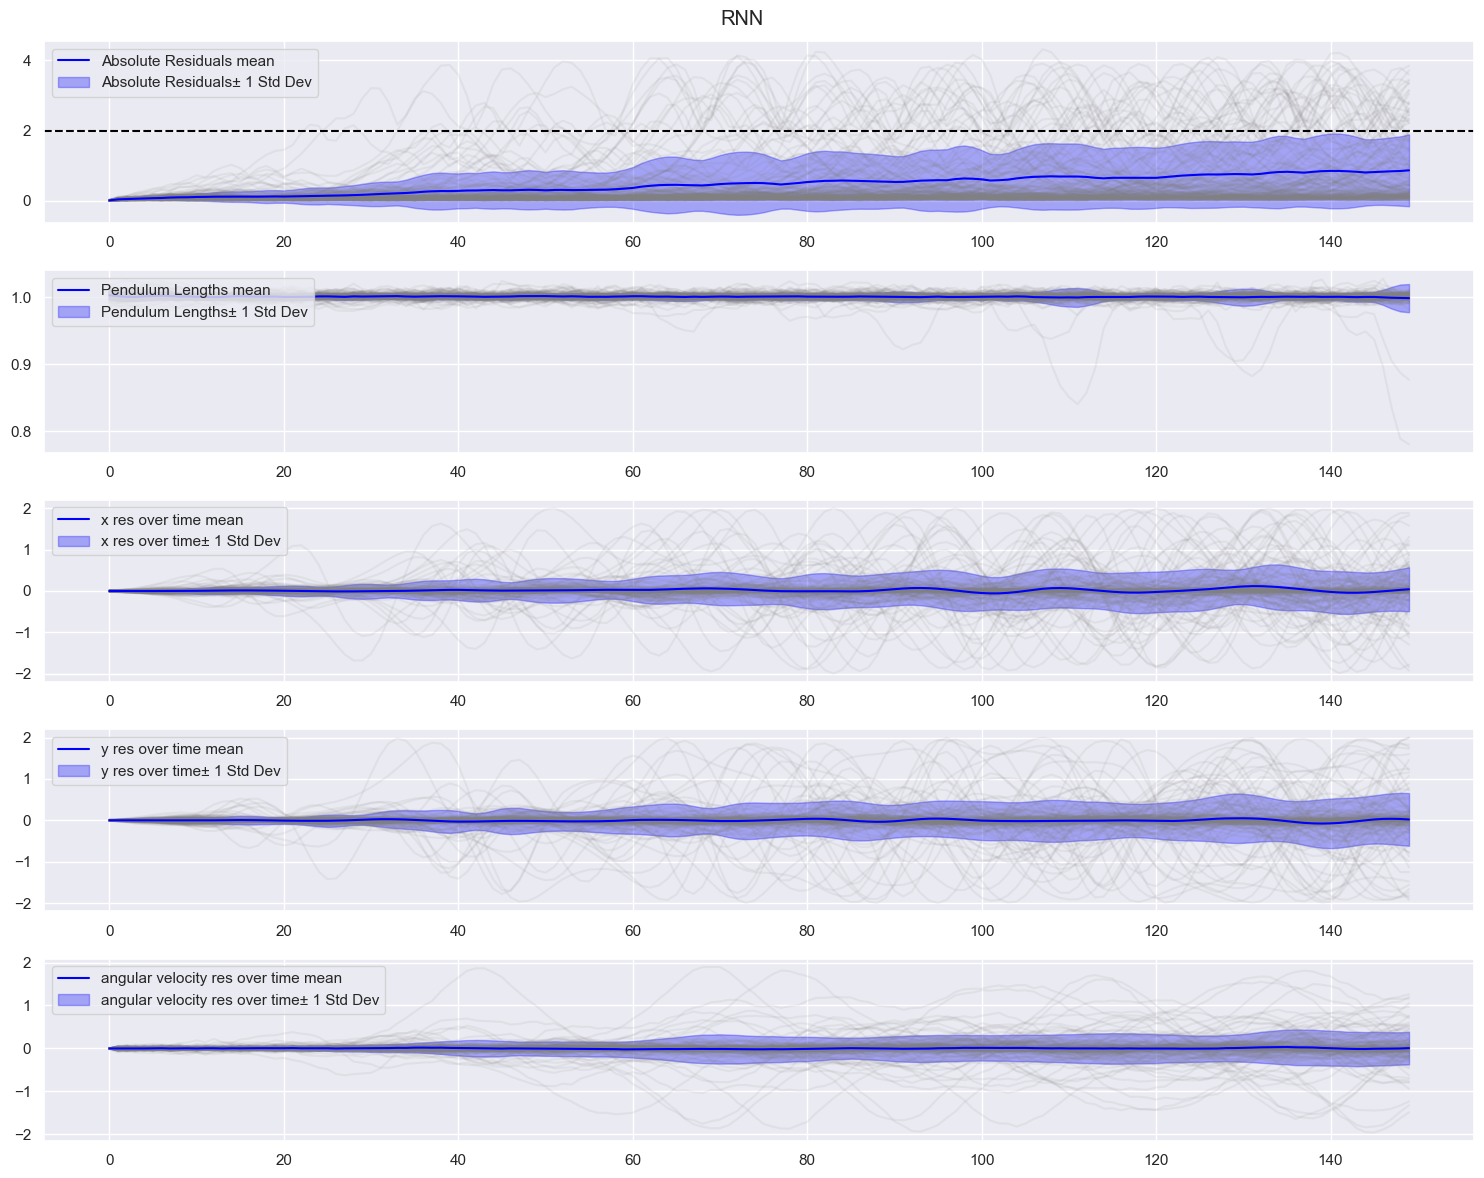

In [ ]:
# Plot Data
fig, axs = plt.subplots(5, 1, figsize=(15, 12))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :3] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("RNN")

plot_feature_trajectory(axs[0], sum_residuals, "Absolute Residuals", n_iter, horizon)
axs[0].axhline(2, c="black", linestyle="dashed") # Dummy Line
plot_feature_trajectory(axs[1], lengths, "Pendulum Lengths", n_iter, horizon)
plot_feature_trajectory(axs[2], residuals[:, :, 0], "x res over time", n_iter, horizon)
plot_feature_trajectory(axs[3], residuals[:, :, 1], "y res over time", n_iter, horizon)
plot_feature_trajectory(axs[4], residuals[:, :, 2], "angular velocity res over time", n_iter, horizon)

fig.tight_layout()

Text(0, 0.5, 'Y')

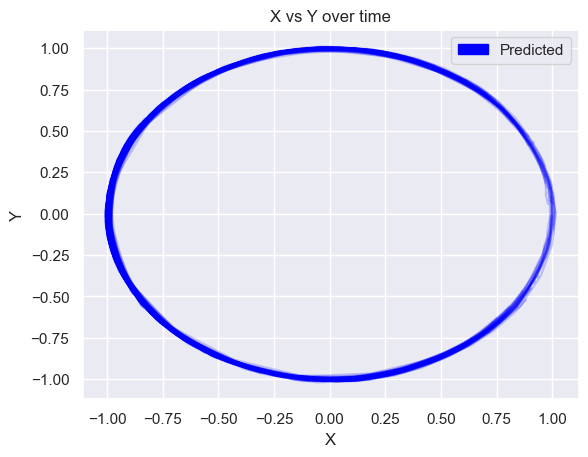

In [ ]:
""" x vs y """
x = preds[:,:,0]
y = preds[:,:,1]

h = 50
for i in range(len(x)):
    plt.plot(x[i,:h], y[i,:h], color='blue', alpha=0.2)

# i = 4
# plt.plot(x[i][:horizon], y[i][:horizon], color='blue', alpha=0.2)
# plt.plot(true_x[i][:horizon], true_y[i][:horizon], color='red', alpha=0.2)

# Add legend with patches
predicted_patch = mpatches.Patch(color='blue', label='Predicted')
plt.legend(handles=[predicted_patch], loc="upper right")

plt.title("X vs Y over time")
plt.xlabel("X")
plt.ylabel("Y")

## Resnet with Noise

In [16]:
class RES_DNN(nn.Module):

    def __init__(self):
        super().__init__()
    
        self.hidden0 = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        self.hidden1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )

        self.hidden2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, state, action):

        o_state = self.hidden0(state)
        o_act = self.hidden1(action)
        o3 = self.hidden2(torch.concatenate((o_state, o_act), dim=1))

        return o3 + state

In [17]:
test_model = RES_DNN()

obs = torch.Tensor([[1, 1, 1], [1, 1, 1]])
act = torch.Tensor([[0.1], [0.1]])
test_model(obs, act).detach()

tensor([[0.8430, 0.7670, 0.9862],
        [0.8430, 0.7670, 0.9862]])

In [18]:
# states_actions is coming from collect_data function, therefore is of shape (num_episodes, episode_length, 4)
def train_res_dnn(model, states_actions, num_epochs, batch_size, lr, multistep=False):
    losses = []
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    # Sort Out Data
    t0_states = states_actions[:,:-2,:3].reshape(-1,3)
    t0_actions = states_actions[:,:-2,3].reshape(-1,1)

    t1_states = states_actions[:,1:-1,:3].reshape(-1,3)
    t1_actions = states_actions[:,1:-1,3].reshape(-1,1)

    t2_states = states_actions[:,2:,:3].reshape(-1,3)

    # Train
    for epoch in range(num_epochs):

        for b_t0_states, b_t0_actions, b_t1_states, b_t1_actions, b_t2_states in create_minibatches(
                batch_size, t0_states, t0_actions, t1_states, t1_actions, t2_states):
            
            b_t0_states += torch.randn(b_t0_states.shape) * 0.005 # Add noise to states

            b_t1_preds = model(b_t0_states, b_t0_actions)
            loss = loss_fn(b_t1_preds, b_t1_states)
            
            if multistep:
                b_t2_preds = model(b_t1_preds, b_t1_actions)
                loss += loss_fn(b_t2_preds, b_t2_states)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
    
    return losses

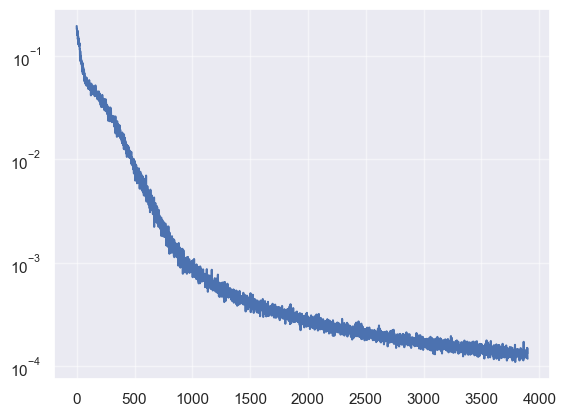

In [ ]:
res_model = RES_DNN()
normalize_velocity=True
states_actions = collect_samples(env, 50, normalize_velocity=normalize_velocity) # returns (n_iter, ep_length, 4)
losses = train_res_dnn(res_model, states_actions, 100, 256, 1e-4, multistep=True) # Multistep improvement is negligible
plt.plot(losses)
plt.yscale("log")
plt.grid(alpha=0.5);

## Test Resnet

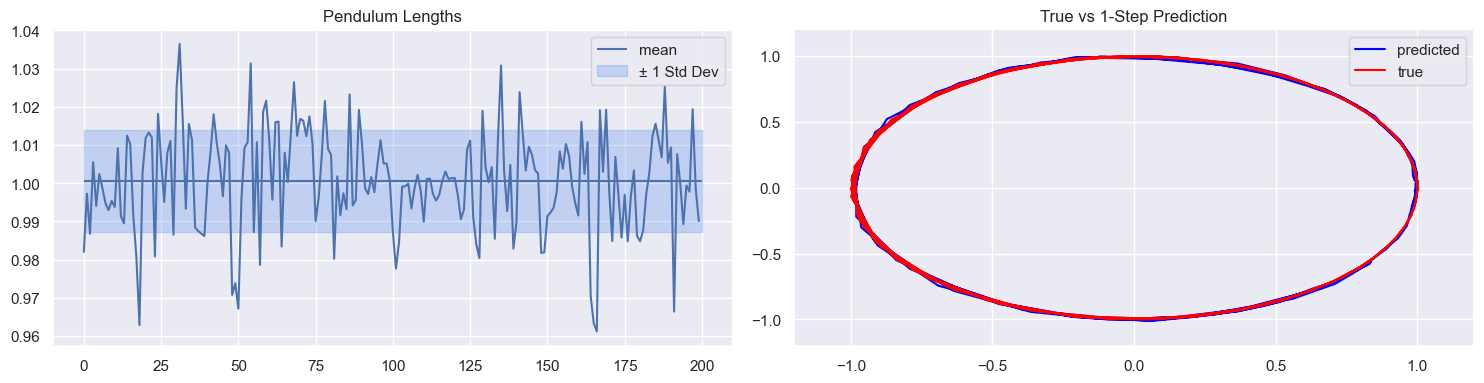

In [ ]:
# Collect Data
states_actions = collect_samples(env, 1, normalize_velocity=normalize_velocity)[0]
t0_states = states_actions[:,:3]
t0_actions = states_actions[:, 3].unsqueeze(dim=1)
t1_states = states_actions[:, :3]

# Make Predictions
with torch.no_grad():
    t1_preds = res_model(t0_states, t0_actions)

lengths = t1_preds[:,0] ** 2 + t1_preds[:,1] ** 2
lengths_mean = lengths.mean()
lengths_std = lengths.std()

# Plot Data
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(lengths)
axs[0].hlines(lengths_mean, 0, 200, label="mean")
axs[0].fill_between((0, 200), lengths_mean - lengths_std, lengths_mean + lengths_std, color='cornflowerblue', alpha=0.3, label='± 1 Std Dev')
axs[0].set_title("Pendulum Lengths")
axs[0].legend(loc="upper right")

axs[1].plot(t1_preds[:,0], t1_preds[:,1], color="blue", label="predicted")
axs[1].plot(t1_states[:,0], t1_states[:,1], color="red", label="true")
axs[1].set_title("True vs 1-Step Prediction")
axs[1].legend(loc="upper right")
axs[1].set_ylim(-1.2, 1.2)
axs[1].set_xlim(-1.2, 1.2)

fig.tight_layout()

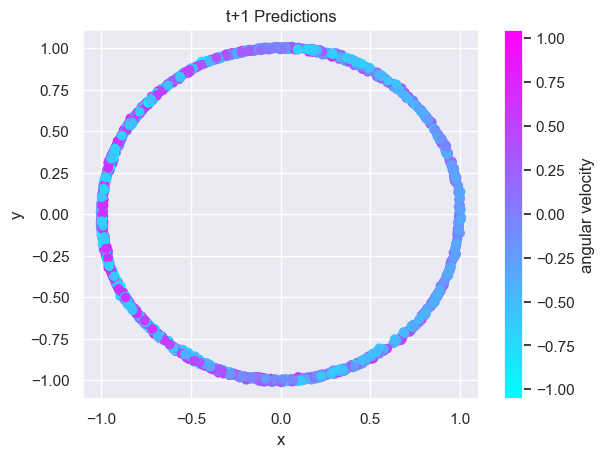

In [ ]:
n_iter = 10
states_actions = collect_samples(env, n_iter, normalize_velocity=normalize_velocity)
states_actions = states_actions.reshape(-1, 4)
states = states_actions[:,:3]
actions = states_actions[:,3].unsqueeze(dim=1)

with torch.no_grad():
    preds = res_model(states, actions)


sc = plt.scatter(preds[:,0], preds[:,1], c=preds[:,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title("t+1 Predictions")
plt.xlabel("x")
plt.ylabel("y");

In [37]:
n_iter = 150
horizon = 150

# Collect Data
states_actions = collect_samples(env, n_iter)


def dnn_rollout(model, n_iter, horizon, states_actions):
    # Start with same start states
    states = states_actions[:, 0, :3]
    actions = states_actions[:, 0, 3].reshape(-1, 1)

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        
        with torch.no_grad():
            pred = model(states, actions)

        states = pred
        actions = states_actions[:, i, 3].reshape(-1, 1)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1)

    return preds, states_actions

# preds, _ = dnn_rollout(res_model, n_iter, horizon, states_actions)
# print(preds.shape) # n_iter, horizon, 3 (obs_size)
# print(states_actions.shape) # n_iter, ep_length, 4 (obs_size + act_size)


Text(0, 0.5, 'y')

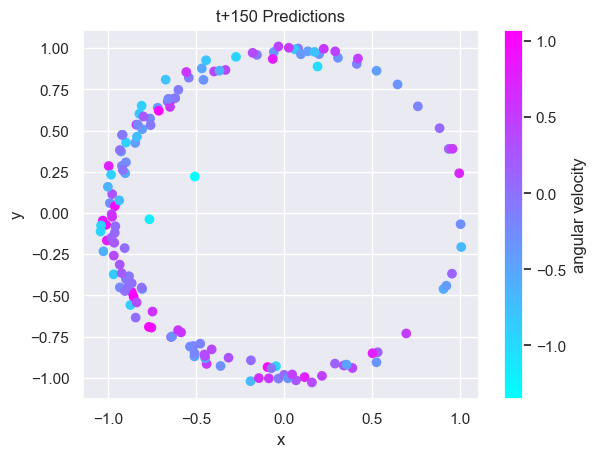

In [ ]:
n = 149
sc = plt.scatter(preds[:,n,0], preds[:,n,1], c=preds[:,n,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title(f"t+{n+1} Predictions")
plt.xlabel("x")
plt.ylabel("y")

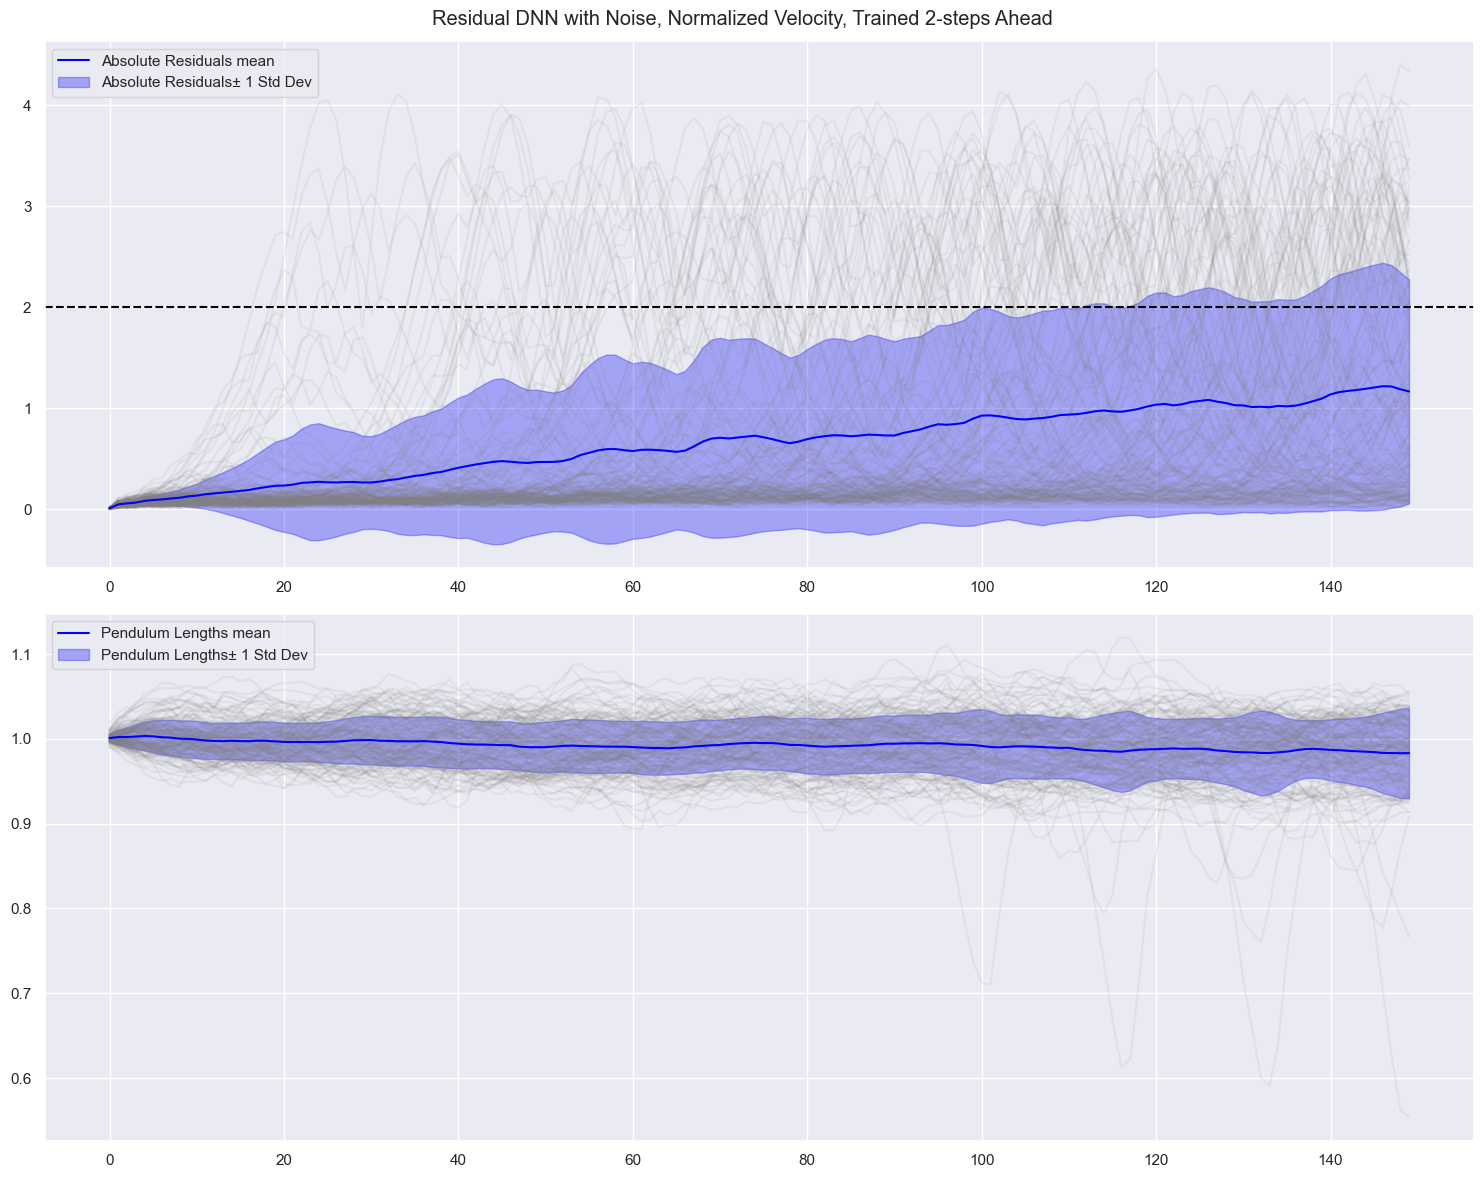

In [ ]:
# Plot Data
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :3] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("Residual DNN with Noise, Normalized Velocity, Trained 2-steps Ahead")

plot_feature_trajectory(axs[0], sum_residuals, "Absolute Residuals", n_iter, horizon)
axs[0].axhline(2, c="black", linestyle="dashed") # Dummy Line
plot_feature_trajectory(axs[1], lengths, "Pendulum Lengths", n_iter, horizon)
# plot_feature_trajectory(axs[2], residuals[:, :, 0], "x res over time", n_iter, horizon)
# plot_feature_trajectory(axs[3], residuals[:, :, 1], "y res over time", n_iter, horizon)
# plot_feature_trajectory(axs[4], residuals[:, :, 2], "angular velocity res over time", n_iter, horizon)

fig.tight_layout()

Text(0, 0.5, 'Y')

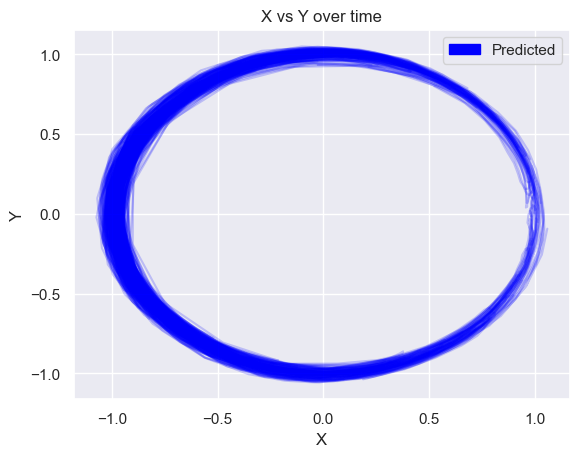

In [ ]:
""" x vs y """
x = preds[:,:,0]
y = preds[:,:,1]

h = 50
for i in range(len(x)):
    plt.plot(x[i,:h], y[i,:h], color='blue', alpha=0.2)

# i = 4
# plt.plot(x[i][:horizon], y[i][:horizon], color='blue', alpha=0.2)
# plt.plot(true_x[i][:horizon], true_y[i][:horizon], color='red', alpha=0.2)

# Add legend with patches
predicted_patch = mpatches.Patch(color='blue', label='Predicted')
plt.legend(handles=[predicted_patch], loc="upper right")

plt.title("X vs Y over time")
plt.xlabel("X")
plt.ylabel("Y")

## Recurrent Resnet

In [ ]:
class RESRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)

        # residual connection
        out = out + x[:,:,:3] # the entire batch, sequence, and just the state
        
        return out, ht

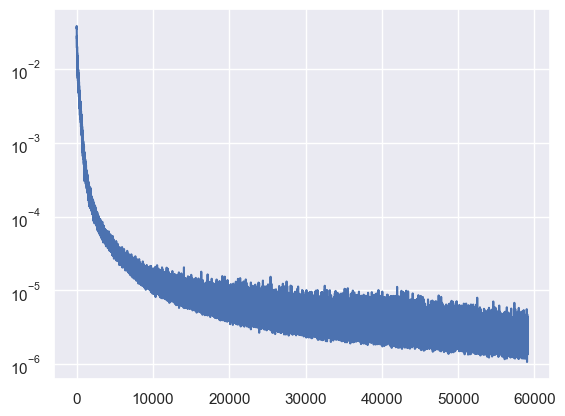

In [ ]:
res_rnn_model = RESRNN(obs_space_size, action_space_size, hidden_size=64)
losses = train_rnn(env, res_rnn_model, num_epochs=100, num_episodes=200, sequence_length=10, batch_size=64, lr=1e-4, device="cpu", multistep=False) # multistep no work
plt.plot(losses)
plt.yscale("log")

In [ ]:
n_iter = 150
horizon = 150
preds, states_actions = rnn_rollout(res_rnn_model, n_iter, horizon)

print(f"{preds.shape = }")
print(f"{states_actions.shape = }")

preds.shape = torch.Size([150, 150, 3])
states_actions.shape = torch.Size([150, 200, 4])


Text(0, 0.5, 'y')

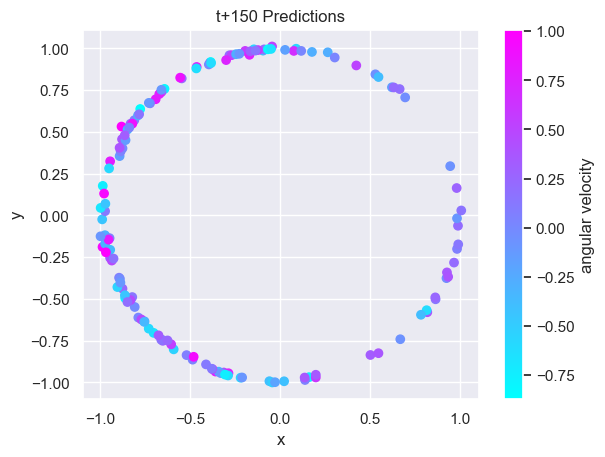

In [ ]:
n = 149
sc = plt.scatter(preds[:,n,0], preds[:,n,1], c=preds[:,n,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title(f"t+{n+1} Predictions")
plt.xlabel("x")
plt.ylabel("y")

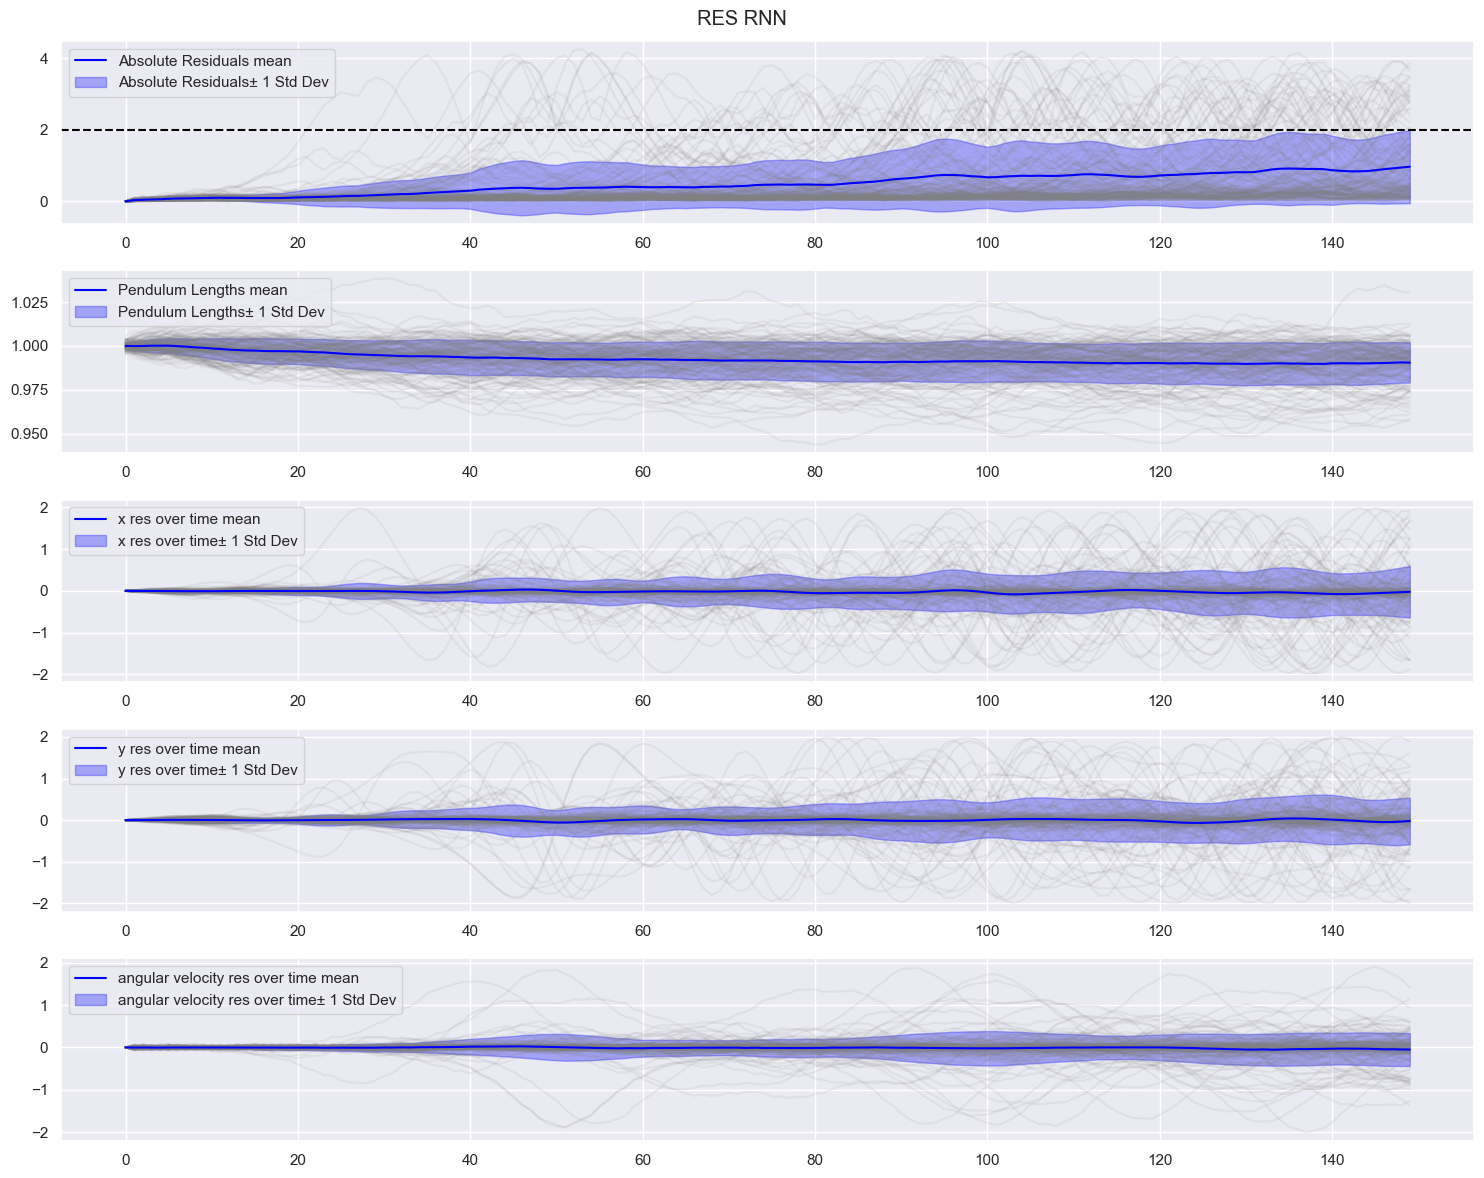

In [ ]:
# Plot Data
fig, axs = plt.subplots(5, 1, figsize=(15, 12))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :3] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("RES RNN")

plot_feature_trajectory(axs[0], sum_residuals, "Absolute Residuals", n_iter, horizon)
axs[0].axhline(2, c="black", linestyle="dashed") # Dummy Line
plot_feature_trajectory(axs[1], lengths, "Pendulum Lengths", n_iter, horizon)
plot_feature_trajectory(axs[2], residuals[:, :, 0], "x res over time", n_iter, horizon)
plot_feature_trajectory(axs[3], residuals[:, :, 1], "y res over time", n_iter, horizon)
plot_feature_trajectory(axs[4], residuals[:, :, 2], "angular velocity res over time", n_iter, horizon)

fig.tight_layout()

## NCPS

In [19]:
import ncps 
from ncps.torch import CfC
from ncps.wirings import NCP

def load_ncps(num_rollouts):
    out_features = 3
    in_features = 4
    #wiring = AutoNCP(6, out_features)
    wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=0, motor_fanin=2)

    num_s = str(num_rollouts) # This is how many rollouts we have, in this case it's 100.
    PATH = f"models/NCPS_N_{num_s}"

    with open(PATH + '/adj_mat.npy', 'rb') as f:
        adj = np.load(f)

    with open(PATH + '/sens_mat.npy', 'rb') as f:
        sens = np.load(f)

    wiring.adjacency_matrix = adj
    wiring.sensory_adjacency_matrix = sens

    NCPS = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) 
    NCPS.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))

    return NCPS

num_rollouts = 100
ncps_model = load_ncps(num_rollouts)

In [20]:
n_iter = 10
states_actions = collect_samples(env, n_iter)
print(f"{states_actions.shape = }")

states_actions = states_actions.reshape(-1, 1, 4)
print(f"{states_actions.shape = }")

with torch.no_grad():
    preds = ncps_model(states_actions)[0]

print(f"{preds.shape = }")

states_actions.shape = torch.Size([10, 200, 4])
states_actions.shape = torch.Size([2000, 1, 4])
preds.shape = torch.Size([2000, 3])


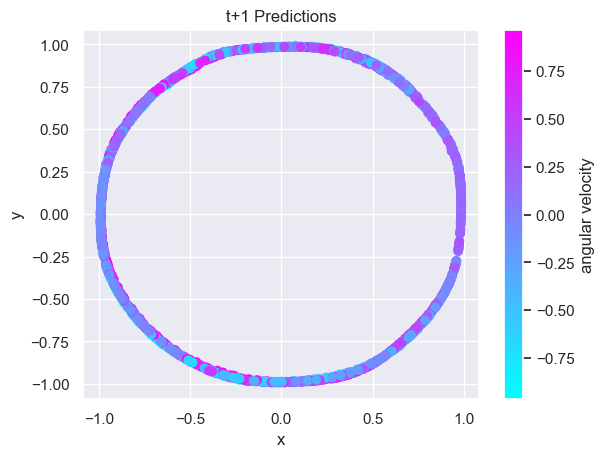

In [21]:
sc = plt.scatter(preds[:,0], preds[:,1], c=preds[:,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title("t+1 Predictions")
plt.xlabel("x")
plt.ylabel("y");

In [22]:
def ncps_rollout(model, n_iter, horizon, states_actions=None):

    # Collect Data
    if states_actions is None:
        states_actions = collect_samples(env, n_iter, normalize_velocity=True)

    # Start with same start states
    input = states_actions[:,0,:]
    ht = None

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        input = input.reshape(n_iter, 1, 4)

        with torch.no_grad():
            pred, _ = model(input)

        input = torch.concatenate((pred.reshape(n_iter, 1, 3), states_actions[:, i, 3].reshape(n_iter, 1, 1)), dim=2)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1).squeeze(dim=2) # dim 2 is the sequence

    return preds, states_actions

# n_iter = 150
# horizon = 199
# preds, states_actions = ncps_rollout(ncps_model, n_iter, horizon)

# print(f"{preds.shape = }")
# print(f"{states_actions.shape = }")

IndexError: too many indices for tensor of dimension 2

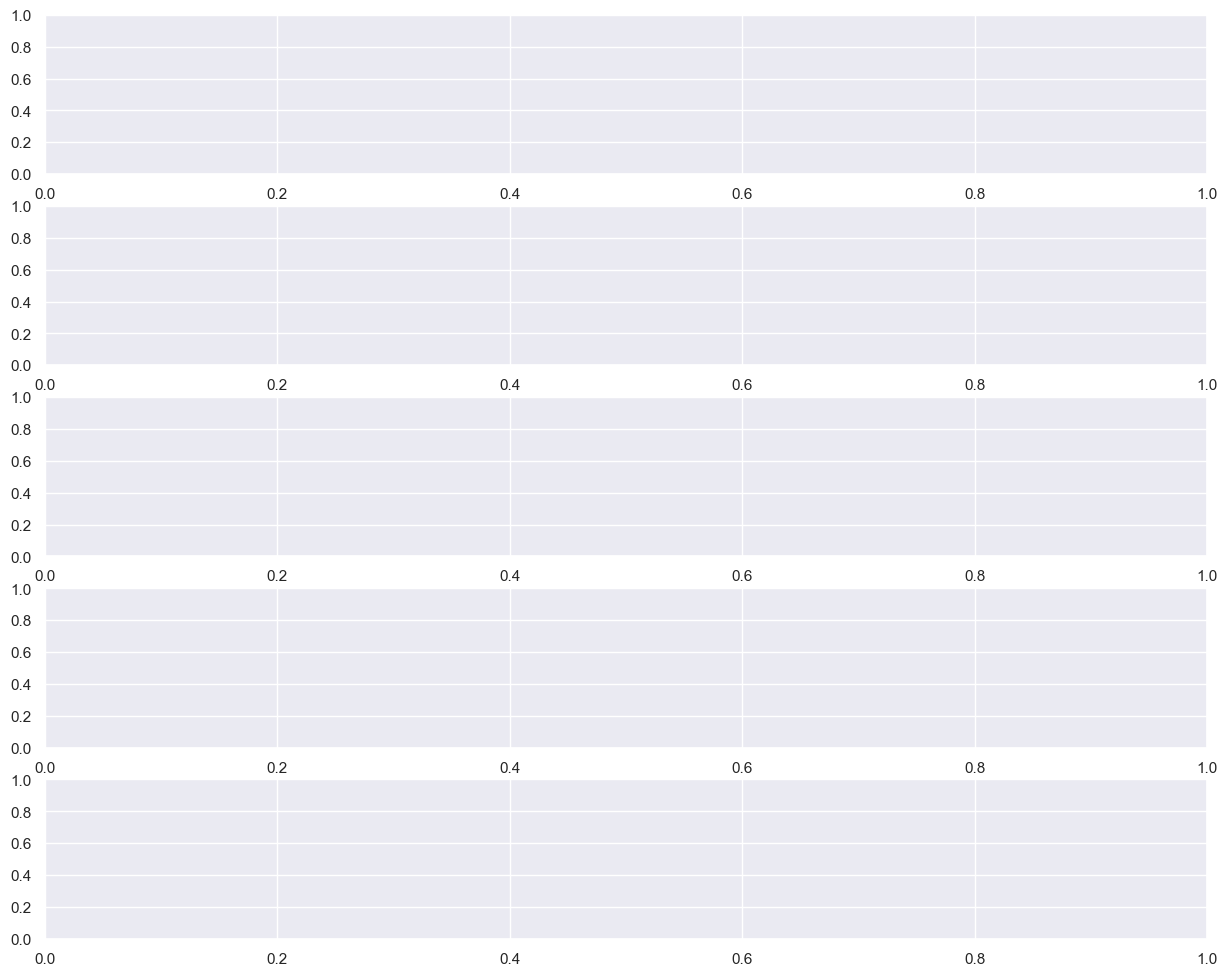

In [23]:
# Plot Data
fig, axs = plt.subplots(5, 1, figsize=(15, 12))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :3] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("NCP")

plot_feature_trajectory(axs[0], sum_residuals, "Absolute Residuals", n_iter, horizon)
axs[0].axhline(2, c="black", linestyle="dashed") # Dummy Line
plot_feature_trajectory(axs[1], lengths, "Pendulum Lengths", n_iter, horizon)
plot_feature_trajectory(axs[2], residuals[:, :, 0], "x res over time", n_iter, horizon)
plot_feature_trajectory(axs[3], residuals[:, :, 1], "y res over time", n_iter, horizon)
plot_feature_trajectory(axs[4], residuals[:, :, 2], "angular velocity res over time", n_iter, horizon)

fig.tight_layout()

## Random Dummy Model

In [24]:
class DummyModel():
    def __init__(self, env, n_iter, normalize_velocity=True):
        states_actions = collect_samples(env, n_iter, normalize_velocity)
        states_actions = states_actions.reshape(-1, 4)
        self.states = states_actions[:,:3]
    
    # Batch size must be first axis of input
    def __call__(self, input):
        size = input.shape[0]
        idx = torch.randint(low=0, high=self.states.shape[0]-1, size=(size,))
        return self.states[idx, :]



In [ ]:
states_actions = collect_samples(env, 10).reshape(-1,4)
dummy = DummyModel(env, 200, True)
dummy(states_actions).shape

torch.Size([2000, 3])

In [ ]:
n_iter = 150
states_actions = collect_samples(env, n_iter, True)
preds = []

for i in range(n_iter):
    pred = dummy(states_actions[i])
    preds.append(pred)

preds = torch.stack(preds, dim=0)
preds.shape, states_actions.shape

(torch.Size([150, 200, 3]), torch.Size([150, 200, 4]))

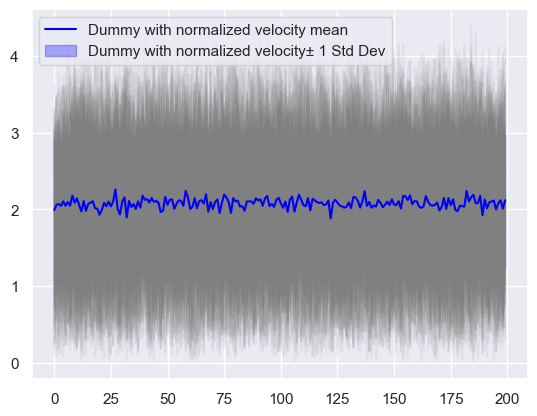

In [ ]:
residuals = states_actions[:,:,:3] - preds
residuals = residuals.abs().sum(dim=2)

figure, ax = plt.subplots(1, 1)
plot_feature_trajectory(ax, residuals, "Dummy with normalized velocity", n_iter, 200)

In [ ]:
residuals.mean().item()

2.078134059906006

## Identity Dummy Model

In [25]:
class IdentityModel():

    def __call__(self, input):
        return input[:,:3]

identity = IdentityModel()

In [ ]:
n_iter = 300
states_actions = collect_samples(env, n_iter, True)
preds = []

for i in range(n_iter):
    pred = identity(states_actions[i])
    preds.append(pred)

preds = torch.stack(preds, dim=0)
preds.shape, states_actions.shape

(torch.Size([300, 200, 3]), torch.Size([300, 200, 4]))

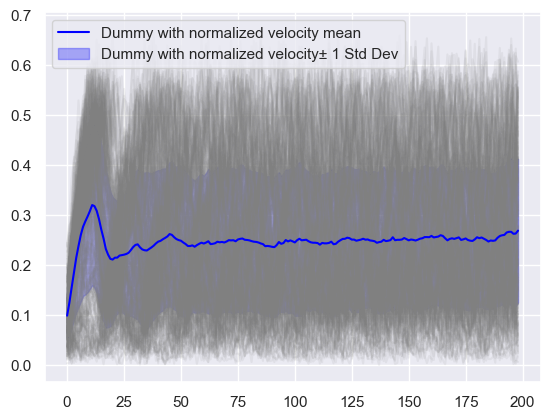

In [ ]:
residuals = states_actions[:,1:,:3] - preds[:,:-1,:3]
residuals = residuals.abs().sum(dim=2)

figure, ax = plt.subplots(1, 1)
plot_feature_trajectory(ax, residuals, "Dummy with normalized velocity", n_iter, 199)

In [ ]:
residuals[:,100:].mean().item() # line seems to be more stable after t=100

0.25173577666282654

## T+1 residual plots (RNN and Resnet)

### RNN

In [ ]:
states_actions = collect_samples(env, 50, normalize_velocity=True)
next_states = states_actions[:, 1:, :3].reshape(-1, 3)
states_actions = states_actions[:, :-1, :].reshape(-1, 1, 4)

with torch.no_grad():
    preds, _ = rnn_model(states_actions)

preds = preds.squeeze(dim=1)

residuals = next_states - preds
residuals.shape, next_states.shape, states_actions.shape

(torch.Size([9950, 3]), torch.Size([9950, 3]), torch.Size([9950, 1, 4]))

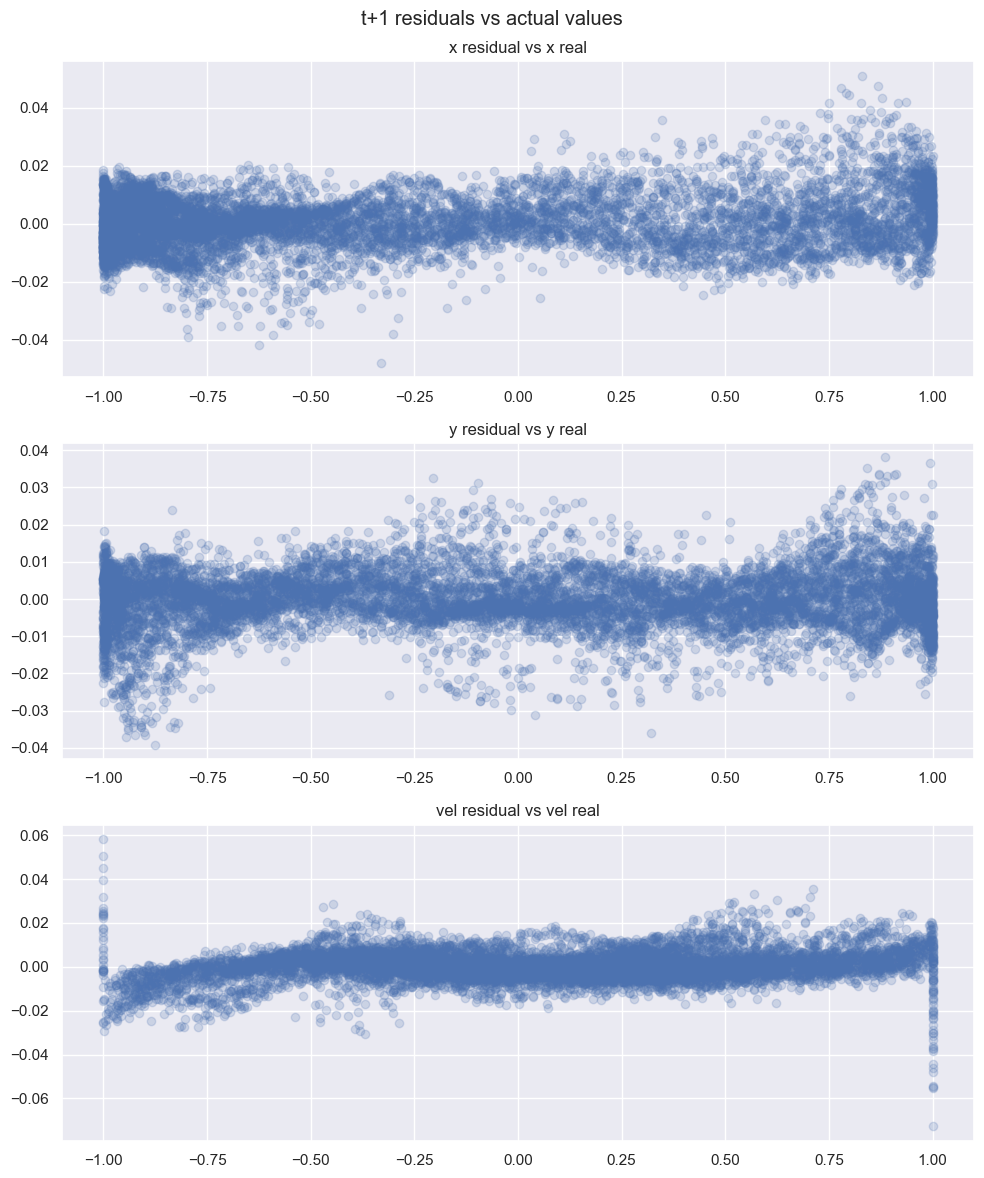

In [ ]:
def residual_plots(real, residuals):
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle("t+1 residuals vs actual values")

    axs[0].scatter(real[:,0], residuals[:,0], alpha=0.2)
    axs[0].set_title("x residual vs x real")

    axs[1].scatter(real[:,1], residuals[:,1], alpha=0.2)
    axs[1].set_title("y residual vs y real")

    axs[2].scatter(real[:,2], residuals[:,2], alpha=0.2)
    axs[2].set_title("vel residual vs vel real")

    fig.tight_layout()

residual_plots(next_states, residuals)

### Resnet

In [ ]:
states_actions = states_actions[:,0,:]
next_states.shape, states_actions.shape

(torch.Size([9950, 3]), torch.Size([9950, 4]))

In [ ]:
# Use same samples as in RNN plots
with torch.no_grad():
    preds = res_model(states_actions[:,:3], states_actions[:,3].unsqueeze(dim=1))

residuals = next_states - preds
residuals.shape

torch.Size([9950, 3])

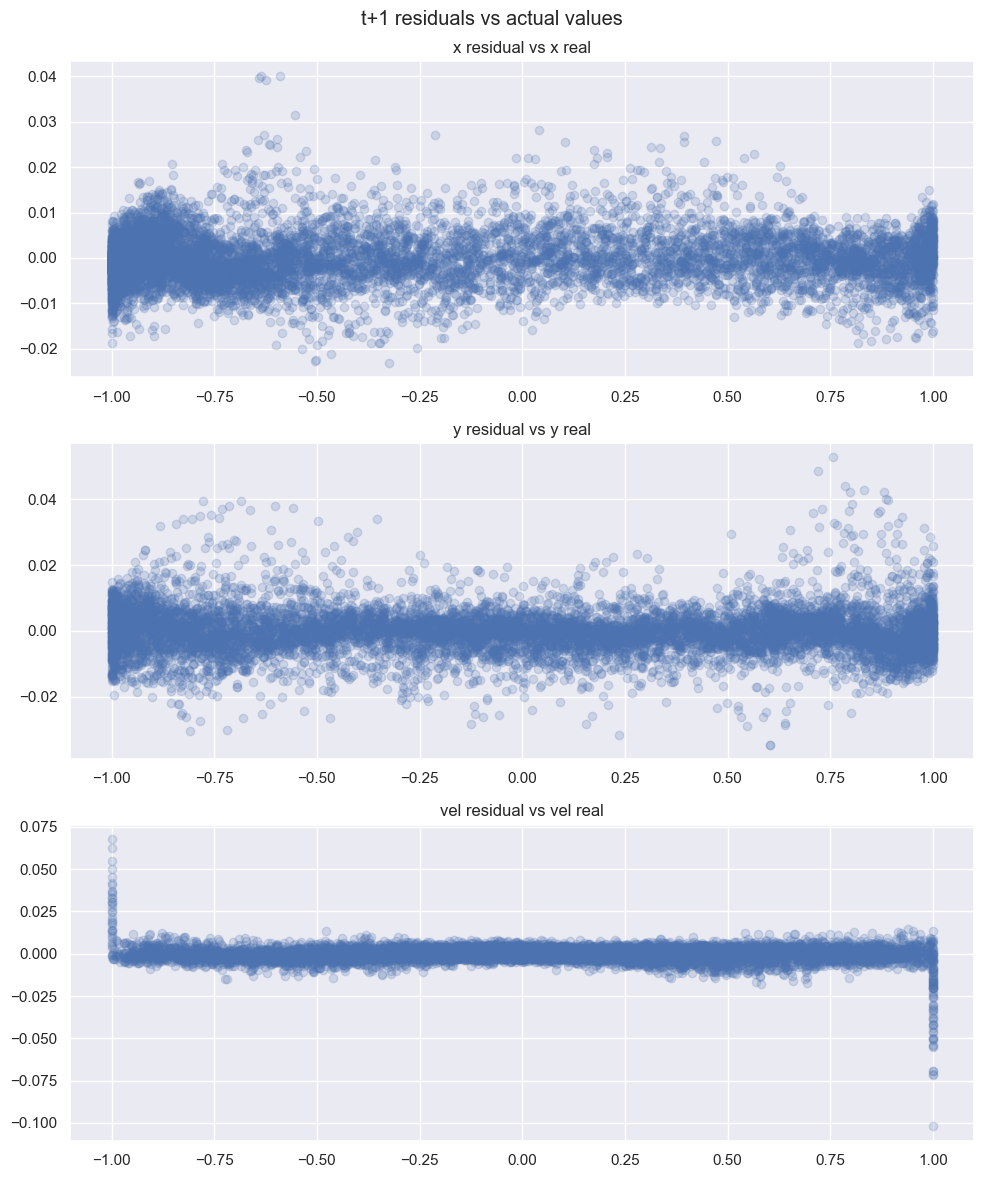

In [ ]:
residual_plots(next_states, residuals)

## Sample Efficiency

In [26]:
num_episodes = [50, 100, 200]

# Hyperparameters
lr = 1e-4
batch_size = 256
num_epochs = 200
sequence_length = 10 # rnn only

### RNN

In [27]:
rnn_models = []
rnn_losses = []

for num_episode in num_episodes:

    # RNN
    rnn_models.append(SimpleRNN(obs_space_size, action_space_size, hidden_size=64))
    rnn_losses.append(train_rnn(env, rnn_models[-1], num_epochs, num_episode, sequence_length, batch_size, lr, device="cpu"))    

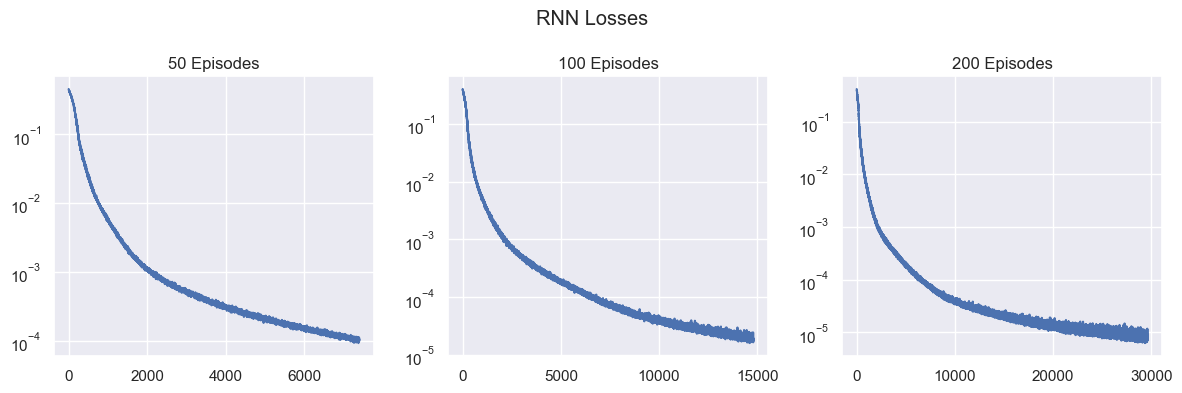

In [28]:
def plot_losses(losses, num_episodes, suptitle):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(len(num_episodes)):
        axs[i].plot(losses[i])
        axs[i].set_title(f"{num_episodes[i]} Episodes")
        axs[i].set_yscale("log")
    fig.suptitle(suptitle)
    fig.tight_layout()

plot_losses(rnn_losses, num_episodes, "RNN Losses")

In [51]:
n_iter = 150
horizon = 199
states_actions = collect_samples(env, n_iter)
print(states_actions.shape)

rnn_preds = []
rnn_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = rnn_rollout(rnn_models[i], n_iter, horizon, states_actions)
    rnn_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    rnn_sum_residuals.append(residuals.abs().sum(dim=2))


torch.Size([150, 200, 4])


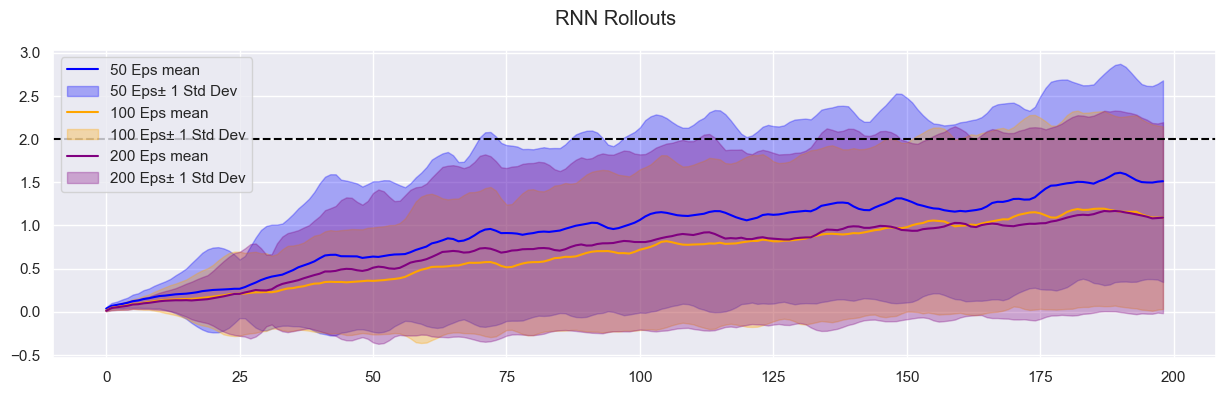

In [52]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("RNN Rollouts")

colors = ["blue", "orange", "purple"]

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, rnn_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line

### Resnet

In [34]:
res_models = []
res_losses = []

for num_episode in num_episodes:

    # Resnet
    normalize_velocity=True
    states_actions = collect_samples(env, num_episode, normalize_velocity=normalize_velocity) # returns (n_iter, ep_length, 4)
    res_models.append(RES_DNN())
    res_losses.append(train_res_dnn(res_models[-1], states_actions, num_epochs, batch_size, lr, multistep=True))

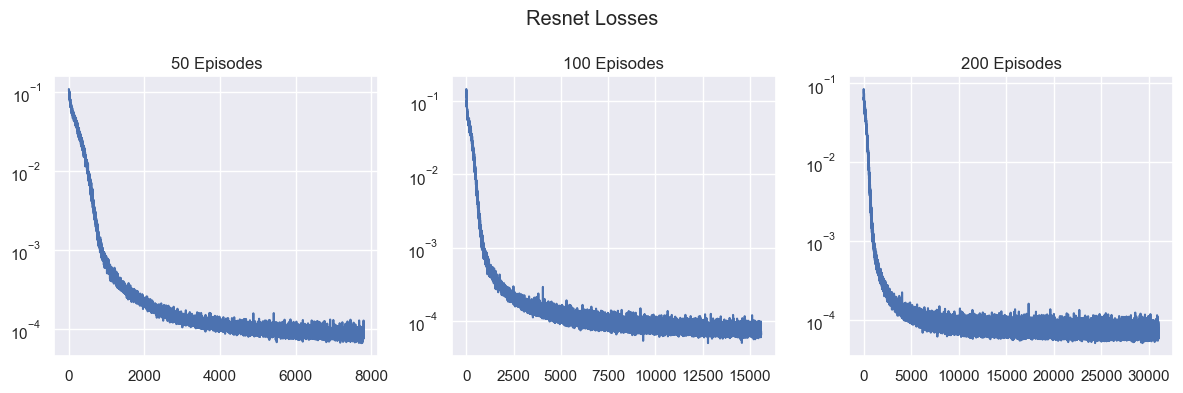

In [35]:
plot_losses(res_losses, num_episodes, "Resnet Losses")

In [53]:
states_actions = collect_samples(env, n_iter)

res_preds = []
res_sum_residuals = []
for i in range(len(num_episodes)):
    preds, _ = dnn_rollout(res_models[i], n_iter, horizon, states_actions)
    res_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    res_sum_residuals.append(residuals.abs().sum(dim=2))

(-0.5, 5.0)

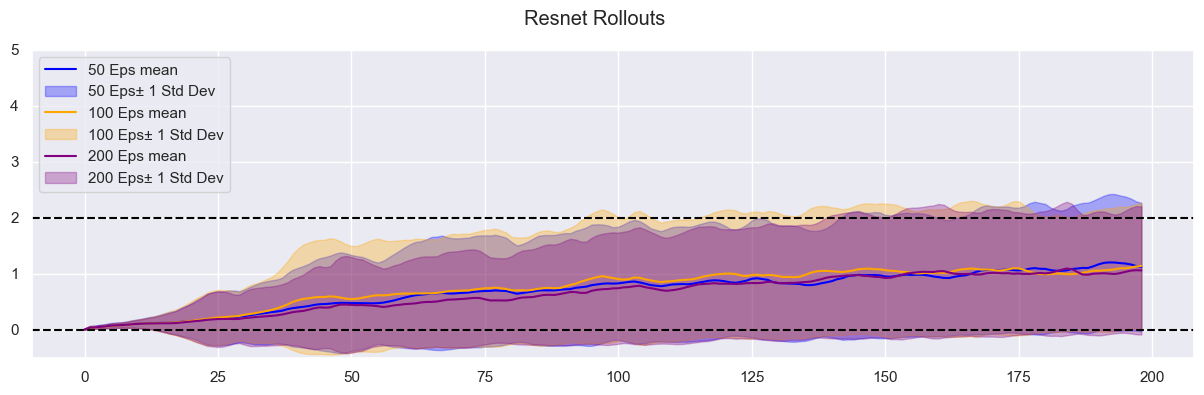

In [54]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("Resnet Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, res_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line
axs.set_ylim(-0.5, 5)

### NCPS

In [40]:
ncps_models = []

for num_episode in num_episodes:
    ncps_models.append(load_ncps(num_episode))

In [55]:
ncps_preds = []
ncps_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = ncps_rollout(ncps_models[i], n_iter, horizon)

    ncps_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    ncps_sum_residuals.append(residuals.abs().sum(dim=2))

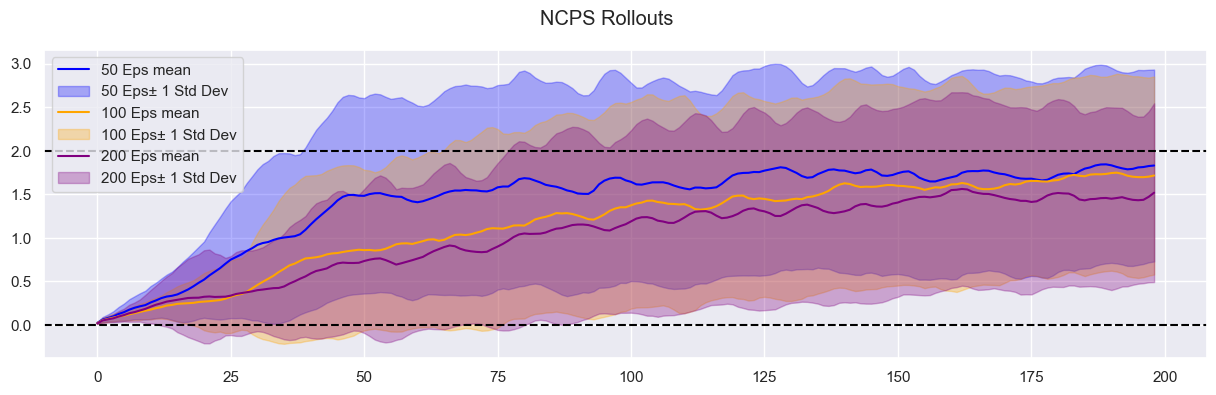

In [56]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("NCPS Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ncps_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### Plotting them together

In [57]:
horizon, rnn_sum_residuals[2].shape, res_sum_residuals[2].shape, ncps_sum_residuals[2].shape

(199, torch.Size([150, 199]), torch.Size([150, 199]), torch.Size([150, 199]))

Text(0.5, 0, 'Time step')

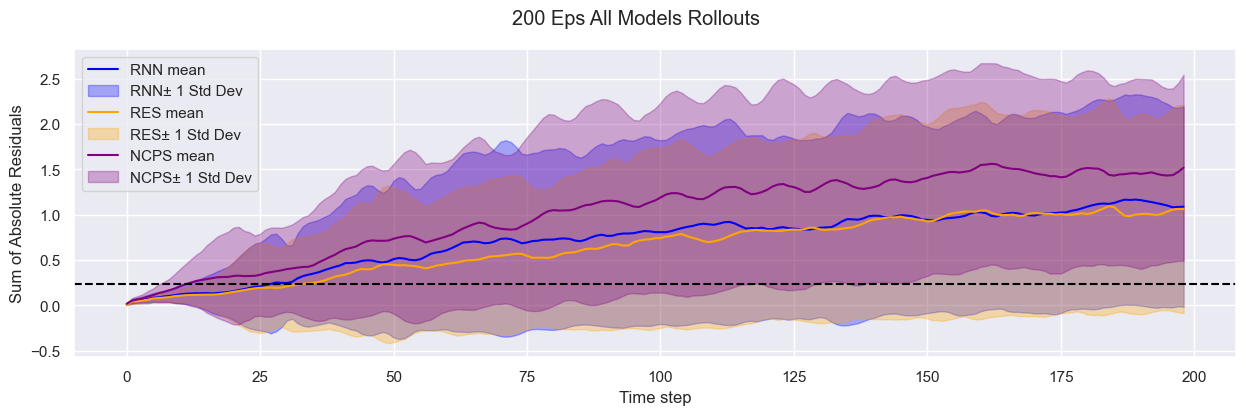

In [58]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("200 Eps All Models Rollouts")

plot_feature_trajectory(axs, rnn_sum_residuals[2], f"RNN", n_iter, horizon, colors[0], False)
plot_feature_trajectory(axs, res_sum_residuals[2], f"RES", n_iter, horizon, colors[1], False)
plot_feature_trajectory(axs, ncps_sum_residuals[2], f"NCPS", n_iter, horizon, colors[2], False)
axs.axhline(0.24, c="black", linestyle="dashed") # Dummy Line
# axs.axhline(0, c="black", linestyle="dashed") # 0 Line

axs.set_ylabel("Sum of Absolute Residuals")
axs.set_xlabel("Time step")

In [59]:
def when_residuals_exceed_threshold(resdiuals, threshold):
    exceeds_threshold = resdiuals > threshold # Find which points are above threshold
    indices = torch.argmax(exceeds_threshold.int(), dim=1) # Find first points above threshold
    indices[~exceeds_threshold.any(dim=1)] = 199    # If no point above threshold, then
                                                    # ~ = bitwise not. ~ + any = No True
    return indices

threshold = 0.24

In [75]:
res_indices = []
rnn_indices = []
ncps_indices = []
for i in range(len(num_episodes)):
    rnn_indices.append(when_residuals_exceed_threshold(rnn_sum_residuals[i], threshold))
    res_indices.append(when_residuals_exceed_threshold(res_sum_residuals[i], threshold))
    ncps_indices.append(when_residuals_exceed_threshold(ncps_sum_residuals[i], threshold))

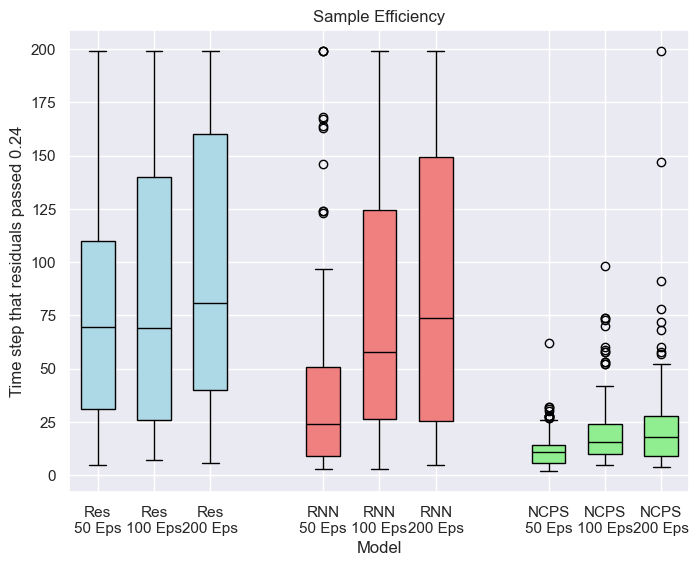

In [76]:
# Define positions for boxplots
x_positions_res = np.array([1, 2, 3])
x_positions_rnn = x_positions_res + 4
x_positions_ncps = x_positions_res + 8
all_positions = np.concatenate([x_positions_res, x_positions_rnn, x_positions_ncps])

# Create figure
plt.figure(figsize=(8, 6))

# Boxplots for Resnet
plt.boxplot(res_indices, positions=x_positions_res, widths=0.6, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))

# Boxplots for RNN
plt.boxplot(rnn_indices, positions=x_positions_rnn, widths=0.6, patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Boxplots for NCPS
plt.boxplot(ncps_indices, positions=x_positions_ncps, widths=0.6, patch_artist=True, 
            boxprops=dict(facecolor="lightgreen"), medianprops=dict(color="black"))

# Labels and titles
labels = ["50 Eps", "100 Eps", "200 Eps"]
x_labels = [f"Res\n{label}" for label in labels] + \
    [f"RNN\n{label}" for label in labels] + \
    [f"NCPS\n{label}" for label in labels]

plt.xticks(all_positions, x_labels)
plt.xlabel("Model")
plt.ylabel(f"Time step that residuals passed {threshold}")
plt.title("Sample Efficiency")

plt.show()


## Out of Distribution Testing with PPO Agent

In [62]:
from state_indep_ppo import PPO

agent = PPO(3, 1)
actor_path = "models/PPO_Actor"
critic_path = "models/PPO_Critic"
agent.actor.load_state_dict(torch.load(actor_path, weights_only=True))
agent.critic.load_state_dict(torch.load(critic_path, weights_only=True))

<All keys matched successfully>

In [63]:
angular_velocity = 2
max_angular_velocity_magnitude = 8

def agent_rollout(env, agent, n_iter):
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(n_iter):
        observation, info = env.reset()
    
        terminated = False
        truncated = False

        c_obs = []
        c_a = []
        c_n_obs = []
    
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            obs = observation
            v_obs = torch.FloatTensor(observation)

            action, log_prob = agent.get_action(v_obs)
    
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
        
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)

        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))

    # Once the episode is done, close the environment
    env.close()

    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)

    t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
    t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude

    states_actions = np.concatenate((t_obs, t_a), axis=2)
    states_actions = torch.from_numpy(states_actions).float()

    return states_actions

n_iter = 50
states_actions = agent_rollout(env, agent, n_iter)
states_actions.shape

torch.Size([50, 200, 4])

### RNN

In [64]:
horizon = 199

ood_rnn_preds = []
ood_rnn_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = rnn_rollout(rnn_models[i], n_iter, horizon, states_actions)
    ood_rnn_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    ood_rnn_sum_residuals.append(residuals.abs().sum(dim=2))

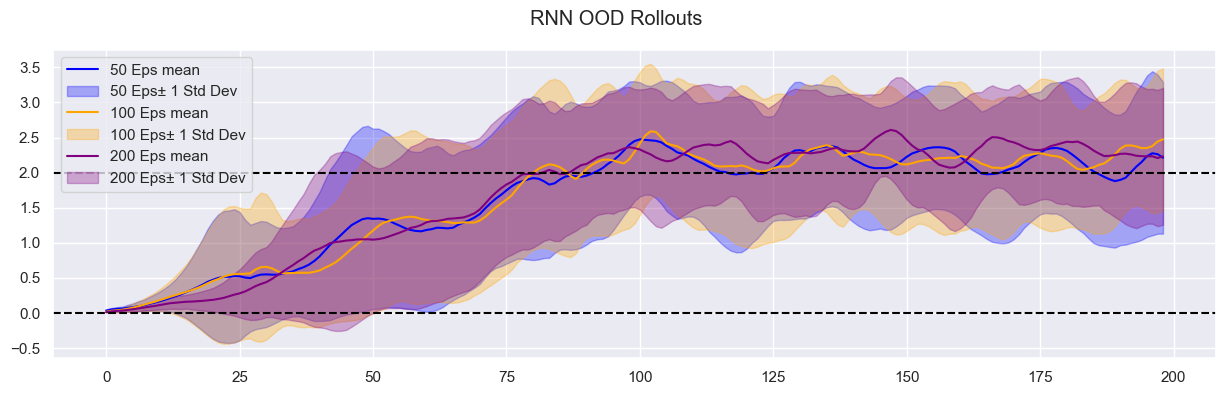

In [65]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("RNN OOD Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ood_rnn_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### Resnet

In [66]:
ood_res_preds = []
ood_res_sum_residuals = []
for i in range(len(num_episodes)):
    preds, _ = dnn_rollout(res_models[i], n_iter, horizon, states_actions)
    ood_res_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    ood_res_sum_residuals.append(residuals.abs().sum(dim=2))

(-0.5, 5.0)

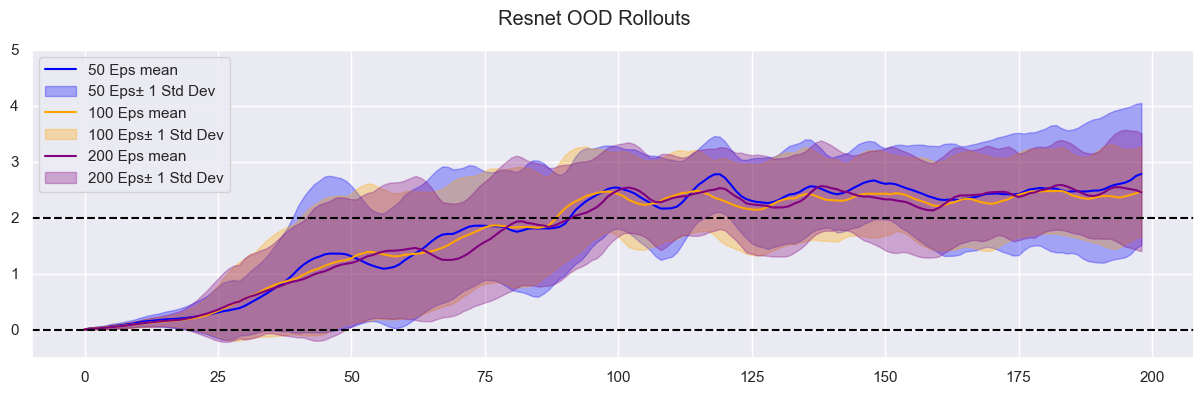

In [67]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("Resnet OOD Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ood_res_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line
axs.set_ylim(-0.5, 5)

### NCPS

In [68]:
ood_ncps_preds = []
ood_ncps_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = ncps_rollout(ncps_models[i], n_iter, horizon, states_actions)

    ood_res_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :3] - preds
    ood_ncps_sum_residuals.append(residuals.abs().sum(dim=2))

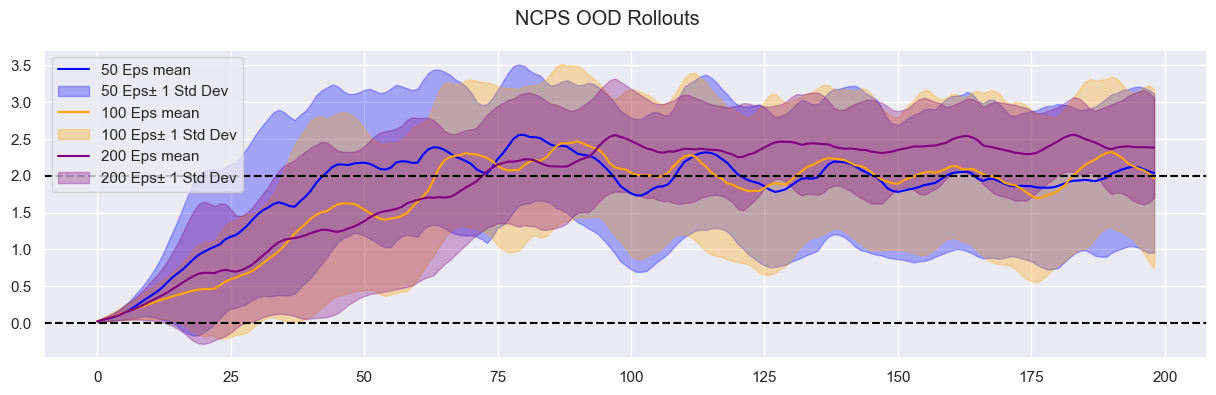

In [69]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("NCPS OOD Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ood_ncps_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### Random Dummy

In [ ]:
dummy = DummyModel(env, 200, True)
dummy(states_actions).shape

torch.Size([50, 3])

In [ ]:
preds = []

for i in range(n_iter):
    pred = dummy(states_actions[i])
    preds.append(pred)

preds = torch.stack(preds, dim=0)
preds.shape, states_actions.shape

(torch.Size([50, 200, 3]), torch.Size([50, 200, 4]))

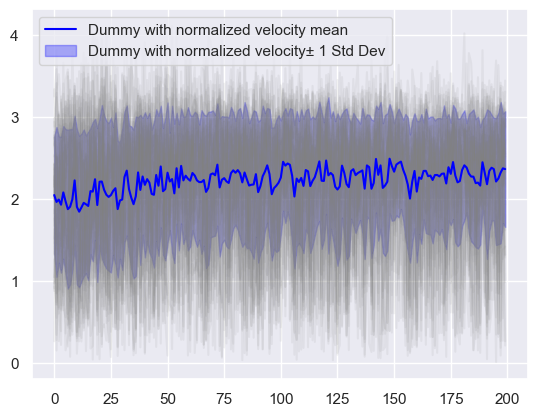

In [ ]:
residuals = states_actions[:,:,:3] - preds
residuals = residuals.abs().sum(dim=2)

figure, ax = plt.subplots(1, 1)
plot_feature_trajectory(ax, residuals, "Dummy with normalized velocity", n_iter, 200)

### Plot them all together

Text(0.5, 0, 'Time step')

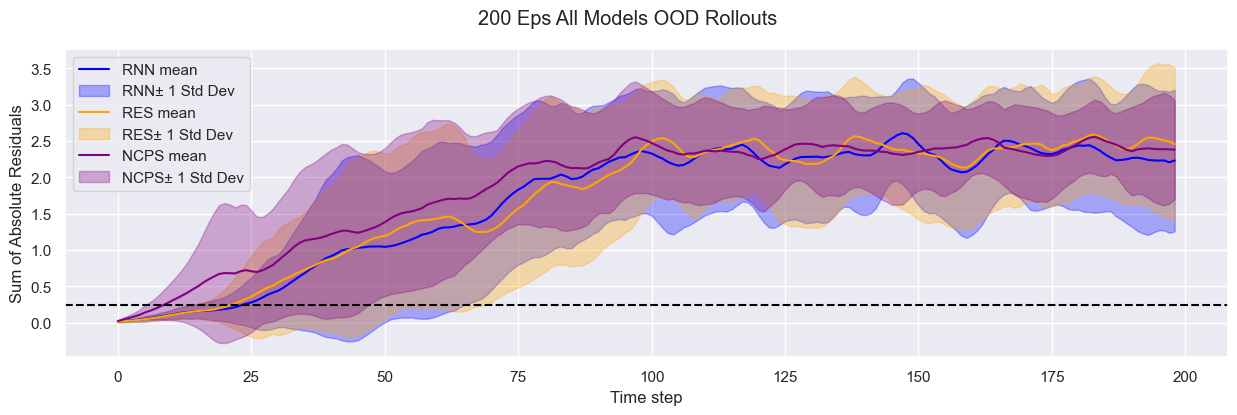

In [70]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("200 Eps All Models OOD Rollouts")

plot_feature_trajectory(axs, ood_rnn_sum_residuals[2], f"RNN", n_iter, horizon, colors[0], False)
plot_feature_trajectory(axs, ood_res_sum_residuals[2], f"RES", n_iter, horizon, colors[1], False)
plot_feature_trajectory(axs, ood_ncps_sum_residuals[2], f"NCPS", n_iter, horizon, colors[2], False)
axs.axhline(0.24, c="black", linestyle="dashed") # Dummy Line
# axs.axhline(0, c="black", linestyle="dashed") # 0 Line

axs.set_ylabel("Sum of Absolute Residuals")
axs.set_xlabel("Time step")

In [72]:
ood_res_indices = []
ood_rnn_indices = []
ood_ncps_indices = []
for i in range(len(num_episodes)):
    ood_rnn_indices.append(when_residuals_exceed_threshold(ood_rnn_sum_residuals[i], threshold))
    ood_res_indices.append(when_residuals_exceed_threshold(ood_res_sum_residuals[i], threshold))
    ood_ncps_indices.append(when_residuals_exceed_threshold(ood_ncps_sum_residuals[i], threshold))

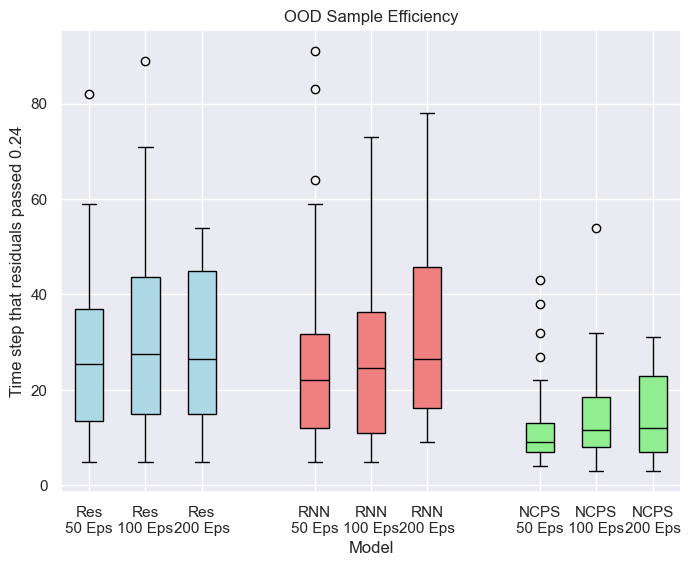

In [73]:
# Define positions for boxplots
x_positions_res = np.array([1, 2, 3])
x_positions_rnn = x_positions_res + 4
x_positions_ncps = x_positions_res + 8
all_positions = np.concatenate([x_positions_res, x_positions_rnn, x_positions_ncps])

# Create figure
plt.figure(figsize=(8, 6))

# Boxplots for Resnet
plt.boxplot(ood_res_indices, positions=x_positions_res, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))

# Boxplots for RNN
plt.boxplot(ood_rnn_indices, positions=x_positions_rnn, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Boxplots for NCPS
plt.boxplot(ood_ncps_indices, positions=x_positions_ncps, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightgreen"), medianprops=dict(color="black"))

# Labels and titles
labels = ["50 Eps", "100 Eps", "200 Eps"]
x_labels = [f"Res\n{label}" for label in labels] + \
    [f"RNN\n{label}" for label in labels] + \
    [f"NCPS\n{label}" for label in labels]

plt.xticks(all_positions, x_labels)
plt.xlabel("Model")
plt.ylabel(f"Time step that residuals passed {threshold}")
plt.title("OOD Sample Efficiency")

plt.show()


## GIFs

In [ ]:
env = gym.make("Pendulum-v1", render_mode='human')

# Reset the environment to get the initial observation
observation, info = env.reset()

terminated = False
truncated = False

while not (terminated or truncated):
    # Get the action from the trained PPO agent
    vect_obs = torch.tensor(observation, dtype=torch.float32, device='cpu')
    action, _ = agent.get_action(vect_obs)  # or .predict(...)
    #print(action)
    # Take a step in the environment
    observation, reward, terminated, truncated, info = env.step(action)

# Once the episode is done, close the environment
env.close()

In [ ]:
states_actions = collect_samples(env, 1)[0]
# states_actions = agent_rollout(env, agent, 1)[0]
# temp = states_actions[:,0].clone()
# states_actions[:,0] = states_actions[:,1]
# states_actions[:,1] = temp
states_actions.shape

torch.Size([200, 4])

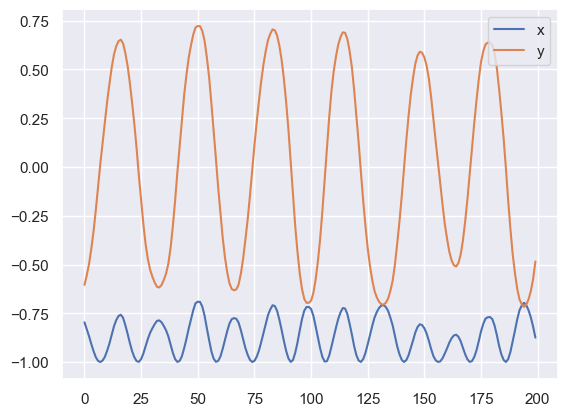

In [ ]:
plt.plot(states_actions[:,0], label="x")
plt.plot(states_actions[:,1], label="y")
plt.legend(loc="upper right")

In [ ]:
res_preds = res_models[2](states_actions[:,:3], states_actions[:,3].reshape(-1, 1)).detach()
res_preds.shape

torch.Size([200, 3])

In [ ]:
rnn_preds, _ = rnn_models[2](states_actions.reshape(-1, 1, 4))
rnn_preds = rnn_preds[:,0,:].detach()
rnn_preds.shape

torch.Size([200, 3])

In [ ]:
ncps_preds, _ = ncps_models[2](states_actions.reshape(-1, 1, 4))
ncps_preds = ncps_preds.detach()
ncps_preds.shape

torch.Size([200, 3])

In [ ]:
t = 0
T = 199

for t in range(T):
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle(f"t+1 Predictions For An Agent Rollout (T={t+1})")

    axs.plot((res_preds[t, 1], 0), (res_preds[t, 0], 0), label="Residual Connection")
    axs.plot((rnn_preds[t, 1], 0), (rnn_preds[t, 0], 0), label="RNN")
    axs.plot((ncps_preds[t, 1], 0), (ncps_preds[t, 0], 0), label="NCP")
    axs.plot((states_actions[t+1, 1], 0), (states_actions[t+1, 0], 0), label="Ground Truth")
    axs.set_ylim(-1.2, 1.2)
    axs.set_xlim(-1.2, 1.2)
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    axs.legend(loc="upper right")

    plt.savefig(r"plots/t+1_gif/" + str(t+1))
    plt.close()

### T+n GIF

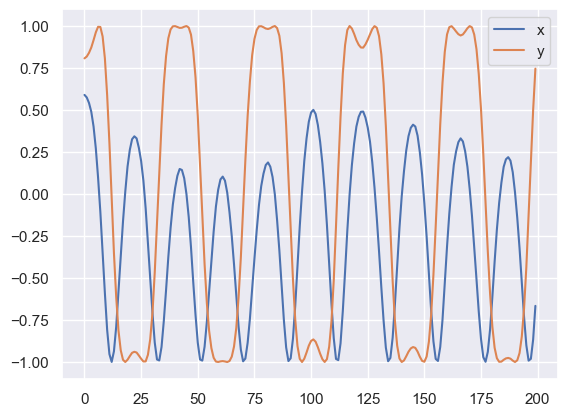

In [ ]:
states_actions = collect_samples(env, 1)
states_actions.shape

plt.plot(states_actions[0, :, 0], label="x")
plt.plot(states_actions[0, :, 1], label="y")
plt.legend(loc="upper right")

In [ ]:
res_preds, _ = dnn_rollout(res_models[2], 1, 199, states_actions)
res_preds = res_preds[0]
res_preds.shape

torch.Size([199, 3])

In [ ]:
rnn_preds, _ = rnn_rollout(rnn_models[2], 1, 199, states_actions)
rnn_preds = rnn_preds[0]
rnn_preds.shape

torch.Size([199, 3])

In [ ]:
ncps_preds, _ = ncps_rollout(ncps_models[2], 1, 199, states_actions)
ncps_preds = ncps_preds[0]
ncps_preds.shape

torch.Size([199, 3])

In [ ]:
states_actions = states_actions[0]
states_actions.shape

torch.Size([200, 4])

In [ ]:
t = 0
T = 199

for t in range(T):
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle(f"t+1 Predictions For A Random Rollout (T={t+1})")

    axs.plot((res_preds[t, 1], 0), (res_preds[t, 0], 0), label="Residual Connection")
    axs.plot((rnn_preds[t, 1], 0), (rnn_preds[t, 0], 0), label="RNN")
    axs.plot((ncps_preds[t, 1], 0), (ncps_preds[t, 0], 0), label="NCP")
    axs.plot((states_actions[t+1, 1], 0), (states_actions[t+1, 0], 0), label="Ground Truth")
    axs.set_ylim(-1.2, 1.2)
    axs.set_xlim(-1.2, 1.2)
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    axs.legend(loc="upper right")

    plt.savefig(r"plots/t+n_gif/" + str(t+1))
    plt.close()